<a href="https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/07_Keras_Flowers_TPU_squeezenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You can try this notebook on a GPU but you will quickly be switching to a TPU. For this model it's worth it.

## Imports

In [1]:
import os, math, json, random, time
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

# little wrinkle: Keras models do not yet work on TPU if eager mode is enabled
# tf.enable_eager_execution()

Tensorflow version 1.14.0-rc0


## Colab-only auth
You would need this if you were accessing private GCS buckets. The training data for this exercise is in a public bucket for which authentication is not necessary.

In [2]:
# IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
# if IS_COLAB_BACKEND:
#   from google.colab import auth
#   auth.authenticate_user()  # not necessary to access a public bucket but you will probably want to access your private buckets too

## TPU detection

In [3]:
# TPUClusterResolver() automatically detects a connected TPU on all Gooogle's
# platforms: Colaboratory, AI Platform (ML Engine), Kubernetes and Deep Learning
# VMs created through the 'ctpu up' utility. If auto-detection is not available,
# you can pass the name of your TPU explicitly:
# tf.contrib.cluster_resolver.TPUClusterResolver('MY_TPU_NAME')
# tip: on a VM created with "ctpu up" the TPU has the same name as the VM.

tpu = gpus = None
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
  tf.tpu.experimental.initialize_tpu_system(tpu)
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
except ValueError:
  gpus = tf.config.experimental.list_logical_devices(device_type="GPU")
  if gpus:
    print("Running on GPU(s): ", gpus)
  else:
    print("Running on CPU")

Running on TPU  ['192.168.44.2:8470']


## Configuration

In [4]:
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
IMAGE_SIZE = [192, 192]

if tpu:
  BATCH_SIZE = 128  # On TPU in Keras, this is the per-core batch size. The global batch size is 8x this.
else:
  BATCH_SIZE = 32  # On Colab/GPU, a higher batch size does not help and sometimes does not fit on the GPU (OOM)

VALIDATION_SPLIT = 0.19
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)

# splitting data files between training and validation
filenames = tf.gfile.Glob(GCS_PATTERN)
random.shuffle(filenames)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE  # 3670 is the numer of images in the dataset
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 128, there will be 23 batches per training epoch and 5 batch(es) per validation run.


In [5]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  if tf.executing_eagerly():
    # In eager mode, iterate in the Datset directly.
    for images, labels in dataset:
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      break;
      
  else: # In non-eager mode, must get the TF note that 
        # yields the nextitem and run it in a tf.Session.
    get_next_item = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as ses:
      numpy_images, numpy_labels = ses.run(get_next_item)

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  label = np.argmax(label, axis=-1)  # one-hot to class number
  correct_label = np.argmax(correct_label, axis=-1) # one-hot to class number
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[np.argmax(labels[i], axis=-1)]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(predictions[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Read images and labels from TFRecords

In [6]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    class_label = tf.cast(example['class'], tf.int32)
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, use "interleave(tf.data.TFRecordDataset, ...)"
  # to read from multiple TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.Dataset.list_files(GCS_PATTERN)
  dataset = dataset.with_options(option_no_order)
  #dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=16)
  dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO) # faster
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

W0610 17:43:24.634374 140616984106752 deprecation.py:323] From <ipython-input-5-abb7fa724837>:15: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


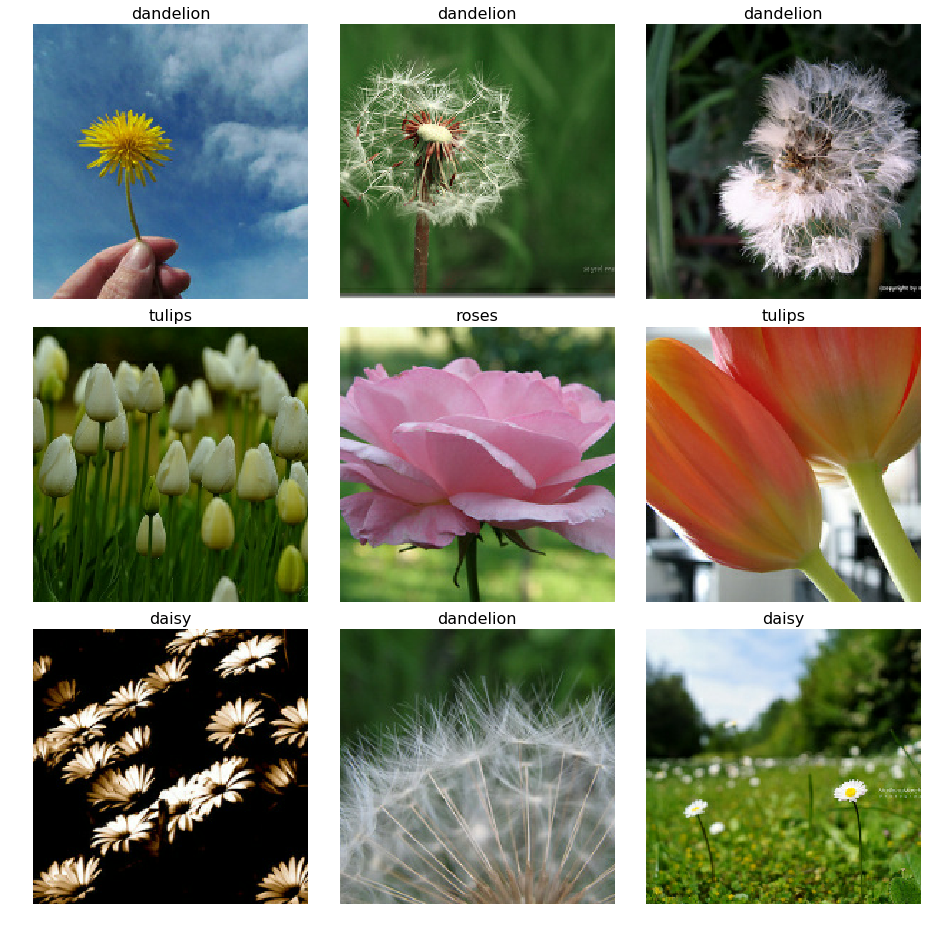

In [7]:
display_9_images_from_dataset(load_dataset(training_filenames))

## training and validation datasets

In [8]:
def get_batched_dataset(filenames):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # drop_remainder will be needed on TPU
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  # For proper ordering of map/batch/repeat/prefetch, see Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets
  return dataset

def get_training_dataset():
  return get_batched_dataset(training_filenames)

def get_validation_dataset():
  return get_batched_dataset(validation_filenames)

some_flowers, some_labels = dataset_to_numpy_util(load_dataset(validation_filenames), 8*20)

## Model

In [9]:
if tpu:
  strategy = tf.distribute.experimental.TPUStrategy(tpu, steps_per_run=100)
elif gpus:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
else:
  strategy = tf.distribute.OneDeviceStrategy("CPU")

In [13]:
np.random.seed(1)
tf.set_random_seed(1)

with strategy.scope():
    
    def fire(x, squeeze, expand):
      y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x)
      y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y)
      y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
      return tf.keras.layers.concatenate([y1, y3])

    def fire_module(squeeze, expand):
      return lambda x: fire(x, squeeze, expand)

    x = tf.keras.layers.Input(shape=[*IMAGE_SIZE, 3]) # input is 192x192 pixels RGB

    # quick downsampling if the input image, with a strides=2 conv layer and a maxpool layer
    y = tf.keras.layers.Conv2D(kernel_size=6, filters=42, padding='same', activation='relu', strides=2)(x)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)  # output is now 48x48

    # it turns out that recognizing flowers does not require many layers
    y = fire_module(squeeze=24, expand=60)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(squeeze=27, expand=90)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y) # output is 12x12x90

    # relatively large dense layer at the end to pick up the filtered pieces and assemble them 
    y = tf.keras.layers.Flatten()(y)  # output is 12x12x90=12960 element vector
    #y = tf.keras.layers.Dropout(0.5)(y) # dropout regularization could be useful here. It also works without it but convergence is not guaranteed on every run.
    y = tf.keras.layers.Dense(5, activation='softmax')(y)

    model = tf.keras.Model(x, y)

    model.compile(
      optimizer=tf.train.AdamOptimizer(),
      loss= 'categorical_crossentropy',
      metrics=['accuracy'])

    model.summary()

# little wrinkle: in eager mode, only tf.train.*Optimizer optimizers will work in model.compile,
# not strings like 'adam' which map to Keras optimizers. Unfortunately the TF optimizers do not
# support Keras learning rate schedules (tf.keras.callbacks.LearningRateScheduler).
# A fix is in the works.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 96, 96, 42)   4578        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 48, 48, 42)   0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 48, 48, 24)   1032        max_pooling2d_3[0][0]            
____________________________________________________________________________________________

## Training

In [14]:
EPOCHS = 20

start_time = time.time()
history = model.fit(get_training_dataset(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                          validation_data=get_validation_dataset(), validation_steps=validation_steps)
end_time = time.time()
print("Time elapsed: ", end_time-start_time, " sec")

Epoch 1/20
23/23 [==============================] - 33s 1s/step - loss: 0.6846 - acc: 0.3410 - val_loss: 1.1901 - val_acc: 0.4875
Epoch 2/20
23/23 [==============================] - 28s 1s/step - loss: 0.6094 - acc: 0.5027 - val_loss: 1.0720 - val_acc: 0.5719
Epoch 3/20
23/23 [==============================] - 30s 1s/step - loss: 0.5106 - acc: 0.5625 - val_loss: 1.0258 - val_acc: 0.5938
Epoch 4/20
23/23 [==============================] - 32s 1s/step - loss: 0.4639 - acc: 0.6202 - val_loss: 0.9576 - val_acc: 0.6266
Epoch 5/20
23/23 [==============================] - 32s 1s/step - loss: 0.4723 - acc: 0.6478 - val_loss: 0.9288 - val_acc: 0.6547
Epoch 6/20
23/23 [==============================] - 34s 1s/step - loss: 0.4521 - acc: 0.6729 - val_loss: 0.8878 - val_acc: 0.6656
Epoch 7/20
23/23 [==============================] - 35s 2s/step - loss: 0.4093 - acc: 0.6892 - val_loss: 0.7988 - val_acc: 0.7078
Epoch 8/20
23/23 [==============================] - 36s 2s/step - loss: 0.3924 - acc: 0.70

dict_keys(['acc', 'val_acc', 'val_loss', 'loss'])


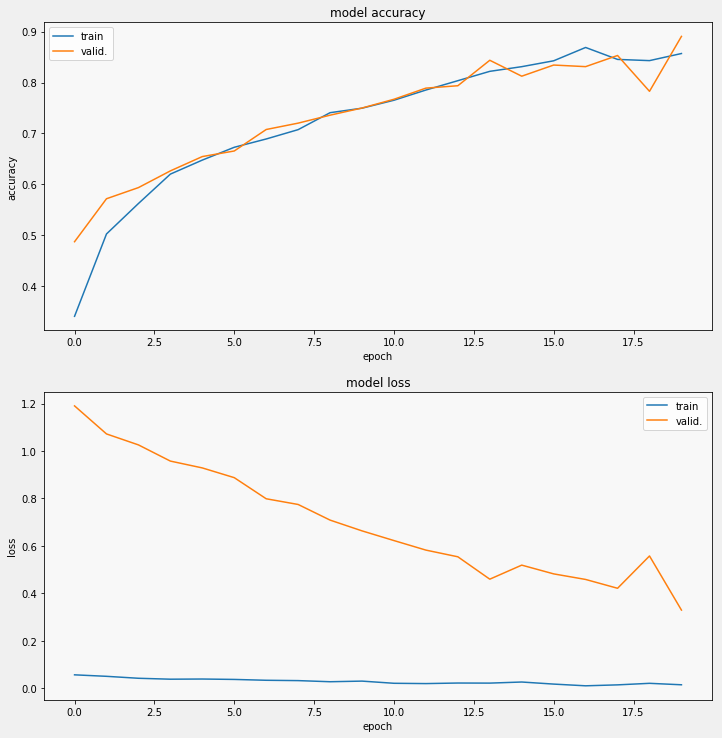

In [15]:
print(history.history.keys())
display_training_curves(history.history['acc'], history.history['val_acc'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## Predictions

In [16]:
# randomize the input so that you can execute multiple times to change results
permutation = np.random.permutation(8*20)
some_flowers, some_labels = (some_flowers[permutation], some_labels[permutation])

predictions = model.predict(some_flowers, batch_size=16)
evaluations = model.evaluate(some_flowers, some_labels, batch_size=16)
  
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
print('[val_loss, val_acc]', evaluations)

10/10 [==============================] - 38s 4s/step
['tulips', 'daisy', 'sunflowers', 'dandelion', 'roses', 'daisy', 'dandelion', 'roses', 'dandelion', 'dandelion', 'tulips', 'roses', 'dandelion', 'dandelion', 'tulips', 'dandelion', 'roses', 'daisy', 'dandelion', 'roses', 'daisy', 'sunflowers', 'roses', 'daisy', 'tulips', 'roses', 'tulips', 'tulips', 'daisy', 'dandelion', 'daisy', 'dandelion', 'tulips', 'dandelion', 'daisy', 'dandelion', 'tulips', 'tulips', 'daisy', 'daisy', 'dandelion', 'dandelion', 'sunflowers', 'sunflowers', 'daisy', 'daisy', 'roses', 'tulips', 'dandelion', 'sunflowers', 'tulips', 'tulips', 'dandelion', 'tulips', 'roses', 'daisy', 'daisy', 'daisy', 'daisy', 'dandelion', 'sunflowers', 'dandelion', 'sunflowers', 'roses', 'daisy', 'dandelion', 'daisy', 'dandelion', 'sunflowers', 'sunflowers', 'daisy', 'dandelion', 'tulips', 'sunflowers', 'dandelion', 'sunflowers', 'daisy', 'sunflowers', 'dandelion', 'tulips', 'tulips', 'dandelion', 'dandelion', 'dandelion', 'dandelion

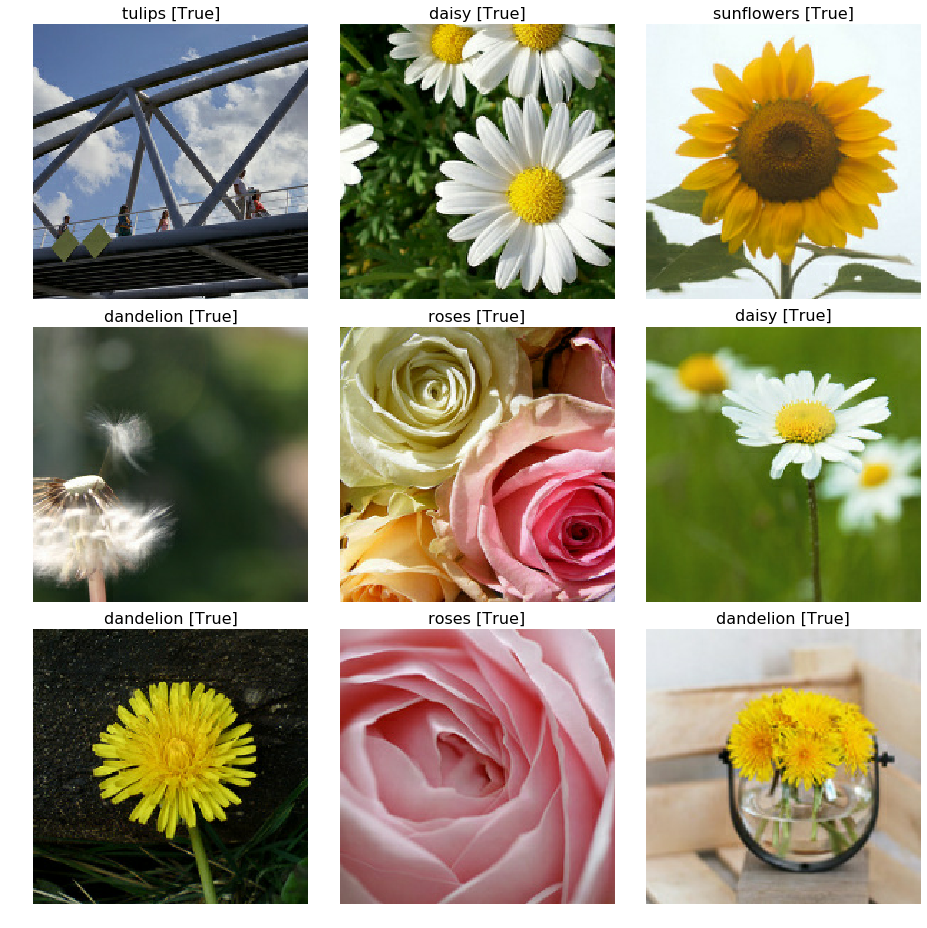

In [17]:
display_9_images_with_predictions(some_flowers, predictions, some_labels)

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
